In [0]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Activation, BatchNormalization, Conv2D, Concatenate
from keras.models import Model, load_model
from datetime import datetime
from keras.callbacks import TensorBoard
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tables
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Tesi/Colab working dir'

# from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

# K.set_image_data_format('channels_last')
# K.set_learning_phase(1)

#!pip install git+https://www.github.com/keras-team/keras-contrib.git
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Tesi/Colab working dir


In [0]:
epoch_num = 100
batch_size = 32
learning_rate = 1e-3
early_stopping_patience = 30
n_blocks = 6
filters = [16, 16, 64]
is_dilated = True
filepath = 'dataset_without_amplitude.mat'
n_channels = 2
#checkpoints_dir = "keras_logs/finalversion/{}blocks_{}-{}-{}".format(n_blocks, filters[0], filters[1], filters[2])
#checkpoints_dir = "keras_logs/finalversion/{}blocks_{}-{}-{}_{}epochs".format(n_blocks, filters[0], filters[1], filters[2], epoch_num)
checkpoints_dir = "keras_logs/noamp/simplenet_{}blocks".format(n_blocks)
if is_dilated:
    checkpoints_dir = checkpoints_dir + "_dilated"
# current_time = datetime.now().strftime("%Y%m%d-%H%M")
# checkpoints_dir = "keras_logs/noamp/{}/".format(current_time)

print(checkpoints_dir)
print("loading dataset")
mat_content = tables.open_file(filepath)

training_data = mat_content.root.training_data[:]
training_label = mat_content.root.training_label[:]
validation_full_data = mat_content.root.validation_full_data[:]
validation_full_label = mat_content.root.validation_full_label[:]
test_data = mat_content.root.test_data[:]
test_label = mat_content.root.test_label[:]


print("training samples: {}".format(len(training_data)))
print("validation samples: {}".format(len(validation_full_data)))
print("test samples: {}".format(len(test_data)))

print(training_data.shape)
print(training_label.shape)
print(validation_full_data.shape)
print(validation_full_label.shape)
print(test_data.shape)
print(test_label.shape)

keras_logs/noamp/simplenet_6blocks_dilated
loading dataset
training samples: 3902
validation samples: 8
test samples: 15
(3902, 128, 128, 2)
(3902, 128, 128, 1)
(8, 500, 920, 2)
(8, 500, 920, 1)
(15, 500, 920, 2)
(15, 500, 920, 1)


In [0]:
def norm(X, name):
    return BatchNormalization(axis = -1, name = name)(X)
    #return InstanceNormalization(name = name)(X)

def simple_block(X, f, filters, block, dilation=1, normalize=False):
    conv_name_base = 'res' + str(block) + "_{}x{}".format(f,f)
    if dilation != 1:
        conv_name_base = conv_name_base + "_dilated"
    bn_name_base = 'norm' + str(block)
    
    X = Conv2D(filters = filters, kernel_size = (f, f), strides = (1, 1), padding = 'same', dilation_rate=dilation, name = conv_name_base)(X)
    if normalize:
        X = norm(X, name = bn_name_base + 'b')
    X = Activation('relu')(X)
    return X

def identity_block(X, f, filters, block, dilation=1):
    
    # Defining name basis
    conv_name_base = 'res' + str(block)
    bn_name_base = 'norm' + str(block)
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + 'a')(X)
    X = norm(X, name = bn_name_base + 'a')
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', dilation_rate=dilation, name = conv_name_base + 'b')(X)
    X = norm(X, name = bn_name_base + 'b')
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + 'c')(X)
    X = norm(X, name = bn_name_base + 'c')

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, block, dilation=1):

    # Defining name basis
    conv_name_base = 'res' + str(block)
    bn_name_base = 'norm' + str(block)

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + 'a')(X)
    X = norm(X, name = bn_name_base + 'a')
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', dilation_rate=dilation, name=conv_name_base + 'b')(X)
    X = norm(X, name = bn_name_base + 'b')
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + 'c')(X)
    X = norm(X, name = bn_name_base + 'c')

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + 's')(X_shortcut)
    #X_shortcut = norm(X_shortcut, name=bn_name_base + 's')

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

def res_block(X, filters, block, dilation=1):
    conv_name_base = 'res' + str(block)
    bn_name_base = 'norm' + str(block)
    
    X_shortcut = X
    
    # First component
    X = Conv2D(filters = filters, kernel_size = (3, 3), strides = (1,1), padding = 'same', dilation_rate=dilation, name = conv_name_base + 'a')(X)
    X = norm(X, name = bn_name_base + 'a')
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = filters, kernel_size = (3, 3), strides = (1,1), padding = 'same', dilation_rate=dilation, name = conv_name_base + 'b')(X)
    X = norm(X, name = bn_name_base + 'b')
    
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def resnet_bottleneck(X):
    kernel_size = 3
    X = convolutional_block(X, 7, filters, block=0)
    for i in range (1, n_blocks):
        dilation = 2 if is_dilated else 1
        X = identity_block(X, kernel_size, filters, block=i, dilation=dilation)
    return X
    
def resnet(X):
    filters = 32
    for i in range (1, n_blocks):
        X = res_block(X, filters, block=i)
    return X

def simple_net(X):
    filters = 32
    X = simple_block(X, 7, filters, 0)
    for i in range (1, n_blocks):
        #dilation = 2 if i%2==0 else 1 #dilation every three blocks
        #normalize = False if i==n_blocks-1 else True
        dilation = 2 if is_dilated else 1
        X = simple_block(X, 3, filters, i, dilation=dilation, normalize=False)
    return X

def generate_model_globalskipconn(n_channels):
    input_shape = (None,None,n_channels)
    
    X_input = Input(shape = input_shape)
    
    X = resnet_bottleneck(X_input)
    X = Conv2D(filters = 2, kernel_size =  (1,1), strides = (1,1), padding = 'same', name = 'down_conv')(X)
    
    X = Concatenate()([X, X_input])
    X = Activation('relu')(X)
    X = Conv2D(filters = 1, kernel_size =  (1,1), strides = (1,1), padding = 'same', name = 'final_conv')(X)
    
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    return model

def generate_model_resnet_bottleneck(n_channels):
    input_shape = (None,None,n_channels)
    
    X_input = Input(shape = input_shape)
    X = resnet_bottleneck(X_input)
    X = Conv2D(filters = 1, kernel_size =  (1,1), strides = (1,1), padding = 'same', name = 'final_conv')(X)
    
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    return model

def generate_model_simple(n_channels):
    input_shape = (None,None,n_channels)
    
    X_input = Input(shape = input_shape)
    X = simple_net(X_input)
    X = Conv2D(filters = 1, kernel_size =  (3,3), strides = (1,1), padding = 'same', name = 'final_conv')(X)
    
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    return model


model = generate_model_resnet_bottleneck(n_channels)
#model.summary()
plot_model(model, to_file='model_scheme.png', show_shapes=True, rankdir='TB')

model.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience)
tensorboard = TensorBoard(log_dir=checkpoints_dir)

model.fit(training_data, 
          training_label, 
          epochs = epoch_num, 
          batch_size = batch_size, 
          validation_data=(validation_full_data, validation_full_label),
          callbacks=[tensorboard, early_stopping])

model.save(checkpoints_dir+"/model.h5")

Train on 3902 samples, validate on 8 samples
Epoch 1/100
3902/3902 [==============================] - 80s 20ms/step - loss: 186.4052 - val_loss: 13.0266
Epoch 2/100
3902/3902 [==============================] - 76s 20ms/step - loss: 3.9125 - val_loss: 3.5816
Epoch 3/100
3902/3902 [==============================] - 76s 20ms/step - loss: 3.1388 - val_loss: 3.1932
Epoch 4/100
3902/3902 [==============================] - 76s 20ms/step - loss: 2.7743 - val_loss: 4.1000
Epoch 5/100
3902/3902 [==============================] - 76s 20ms/step - loss: 2.6443 - val_loss: 4.0233
Epoch 6/100
3902/3902 [==============================] - 76s 20ms/step - loss: 2.5115 - val_loss: 3.5478
Epoch 7/100
3902/3902 [==============================] - 76s 20ms/step - loss: 2.3998 - val_loss: 3.0412
Epoch 8/100
3902/3902 [==============================] - 76s 20ms/step - loss: 2.3399 - val_loss: 4.2563
Epoch 9/100
3902/3902 [==============================] - 76s 19ms/step - loss: 2.2473 - val_loss: 3.9938
Epoch 1

In [0]:
%load_ext tensorboard
%tensorboard --logdir ./keras_logs/

15/15 [==============================] - 6s 419ms/step
mean squared error: 5.358275016148885


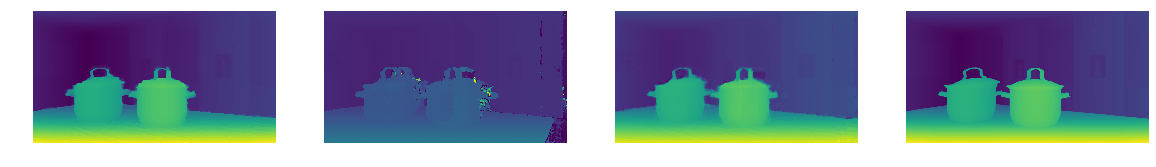

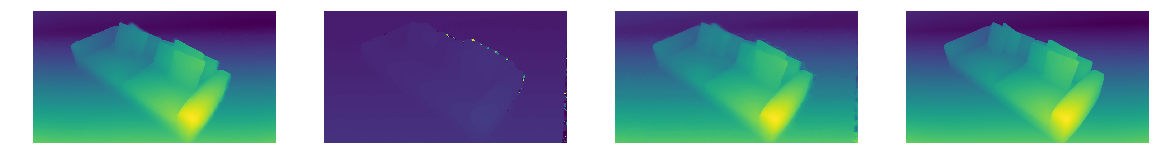

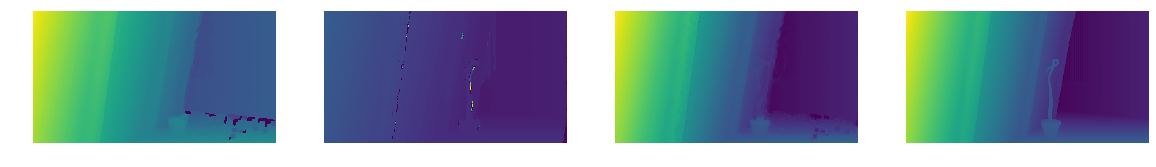

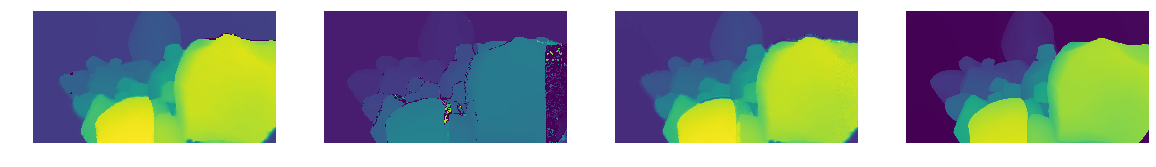

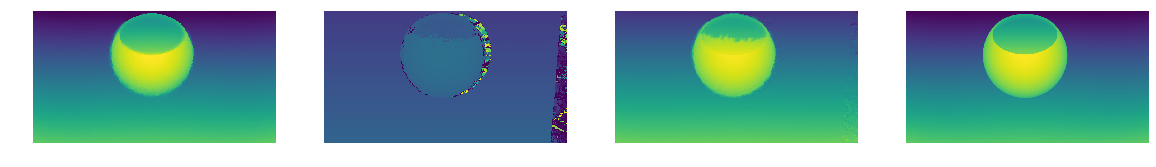

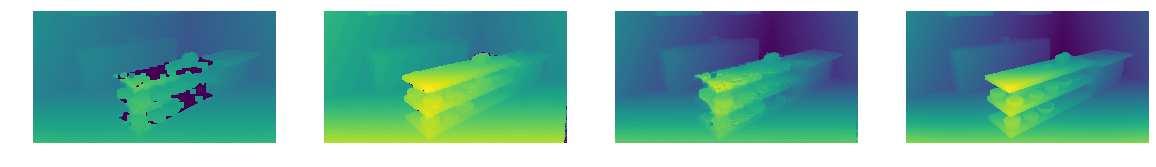

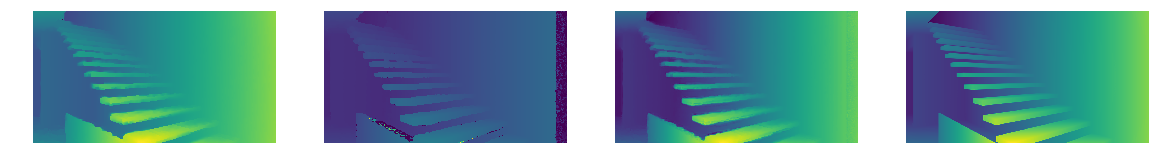

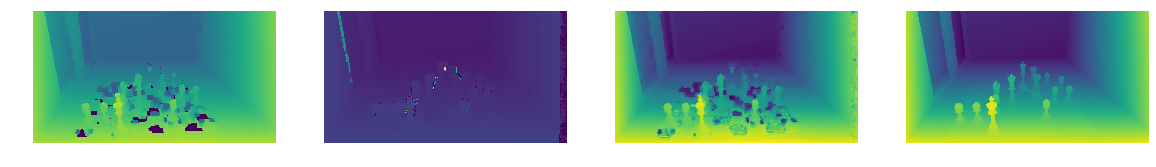

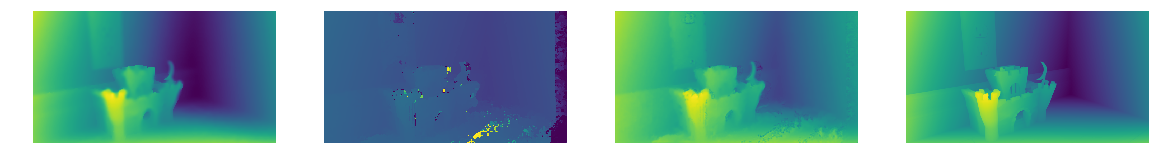

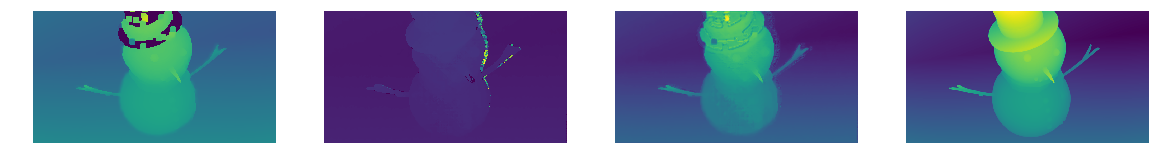

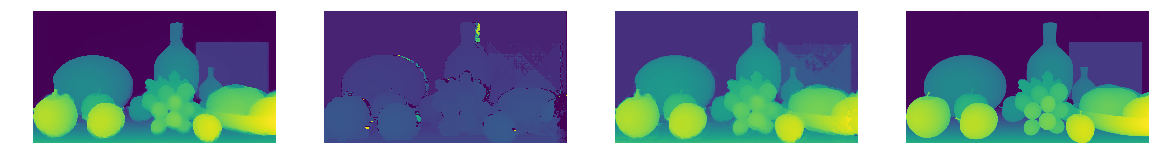

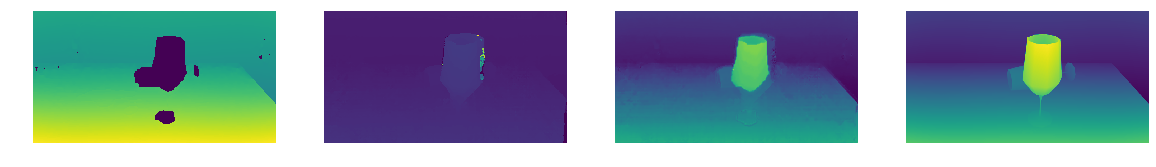

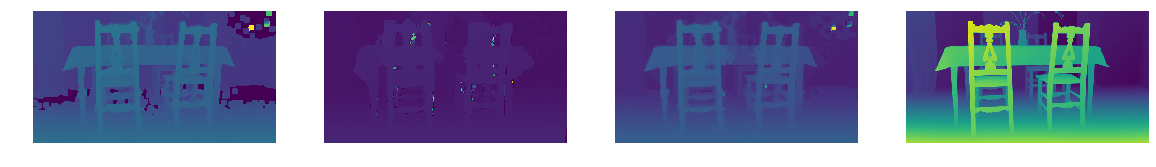

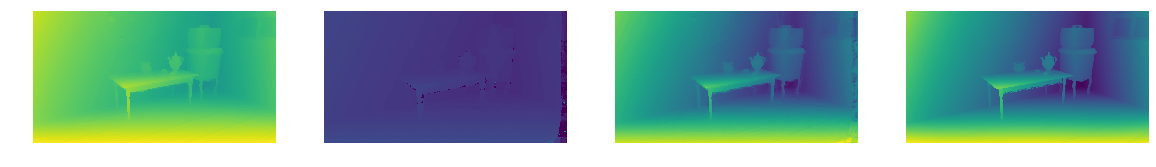

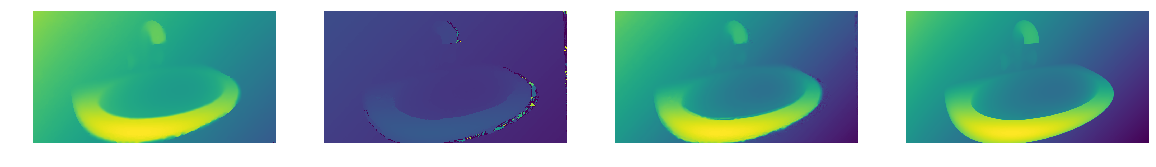

In [0]:
#model = load_model('keras_logs/noamp/version_2_concat/6blocks_32-32-128_dilated_7x7first_withrelu/model.h5')
model = load_model('keras_logs/finalversion/6blocks_16-16-64_dilated/model.h5')
#model = load_model('keras_logs/noamp/simplenet_5blocks/model.h5')
plot_model(model, to_file='model_scheme.png', show_shapes=True, rankdir='TB')
val_or_test = False #True for validation, False for test
data_input = validation_full_data if val_or_test else test_data
data_label = validation_full_label if val_or_test else test_label
batch_size = 4 if val_or_test else 5

mse = model.evaluate(data_input, data_label, batch_size=batch_size)
print("mean squared error: "+str(mse))

outputs = model.predict(data_input, batch_size=batch_size)

def showImagesHorizontally(images):
    fig = plt.figure(figsize=(20, 20))
    number_of_images = len(images)
    for i in range(number_of_images):
        a=fig.add_subplot(1,number_of_images,i+1)
        plt.imshow(images[i])
        plt.axis('off')
        
def showImagesConcatenated(images):
    image = np.concatenate(images, axis=1)
    plt.figure(figsize=(20, 20))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image, vmin=10, vmax=60)
        
for i in range(len(outputs)):
    images = []
    fused = np.squeeze(outputs[i])
    label = np.squeeze(data_label[i])
    tof = np.squeeze(data_input[i,:,:,1])
    stereo = np.squeeze(data_input[i,:,:,0])
    #images.append(np.squeeze(input_images[batch][i,:,:,3])) #stereodiff
    images.append(tof)
    images.append(stereo)
    images.append(fused)
    images.append(label)
    #images.append(np.abs(fused-label)) #difference

    showImagesHorizontally(images)


In [0]:
# for showing intermediate layers outputs
#model = load_model('keras_logs/noamp/6blocks_32-32-128_dilated_7x7first/model.h5')
# input_layer = model.input
# layer_out = model.get_layer("activation_75").output
# model_middle = Model(input=input_layer, outputs=layer_out)
# data = validation_full_data[0:4]
# outputs = model_middle.predict(data, batch_size=4)
# print(np.shape(outputs))

# for sample in range(len(outputs)):
#     images = []
#     for i in range(0,4):
#         images.append(outputs[sample,:,:,i])
#     showImagesHorizontally(images)
    #image = np.concatenate(images, axis=1)
    #plt.figure(figsize=(20, 20))
    #plt.imshow(image, vmin=0, vmax=10)